In [ ]:
"""
Code to test GPU speedup factor using Google Colab GPU.

To switch between Google Colab GPU and CPU:
Runtin -> Change Runtime Type -> GPU/None -> Save

NOTE - import, class definition, and train method cells must be 
re-run every time the runtime is changed. Sometimes, autograd_hacks 
file must be re-uploaded as well. 
"""

In [8]:
"""IMPORTS"""
import math
import time
import torch
import autograd_hacks
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

In [9]:
"""
Created Jan 28 2021

@authors: Alex Lidiak, Caleb Sanders
This model takes as input a FFNN (N inputs, 2 outputs) and converts it into a 
QNADE model. 

The QNADE class performs the autoregressive sample generation, conditional 
wavefunction calculation, and gradient accumulation needed to optimize a 
FFNN to produce the ground state energy of an arbitrary many-body system.  
"""

def calculate_epsilons(model, s, psi_omega, B, J):
        """
        Calculates the E_loc(s) for all sampled states.
        epsilon(s) = sum(s_i * s_i+1) + B/psi_s * sum(psi_s_prime)

        Args: 
            model: QNADE model 
            s: sampled states matrix
            psi_omega: np list of wavefunction coefficients    
            B: int, sigma_x activation
            J: int, sigma_z activation 

        Returns: 
            epsilon: double, epsilon contribution for the given state 
        """
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        N = len(s[0])
        
        z_term = torch.zeros([len(s)]).to(device)

        # sum of the wavefunction coefficients resulting from sigma_x acting on each qubit (per sample)
        psi_s_prime_sum = torch.zeros([len(s)]).to(device)

        for i in range(N):
            
            if i == N-1:
                z_term += s[:,0]*s[:,i]
            else:
                z_term += s[:,i]*s[:,i+1]

            # calculate the sum of psi_s_prime for the sigma_x term
            s_prime = s.clone()
            s_prime[:,i] = -1*s_prime[:,i]
            psi_s_prime,_,_ = model(x=s_prime, requires_grad=False) 
            psi_s_prime_sum += psi_s_prime
        
        x_term = psi_s_prime_sum/psi_omega

        epsilons = -(J*z_term + B*x_term)
        
        return epsilons

class QNADE(nn.Module): # takes a FFNN model as input
            
    def __init__(self, model): 
        super(QNADE, self).__init__()
        
        self.model = model
        self.D = self.model[0].in_features # input layer size
        self.M = self.model[-2].out_features # output layer size
        self.evals = [0,1]
            
    def forward(self, N_samples=None, x=None, requires_grad=True):

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        if N_samples is None and x is None: 
            raise ValueError('Must enter samples or the number of samples to' \
                             ' be generated')
            
        # if not sampling, just calculating wavefunction
        if N_samples is None and x is not None: 
            N_samples, need_samples = x.shape[0], False

        # if sampling and calculating wavefunction
        if N_samples is not None and x is None: 
            need_samples = True
            x = torch.zeros([N_samples,self.D],dtype=torch.float).to(device)
            
        # the full wavefunction is a product of the conditionals
        WAV = torch.ones([N_samples]).to(device) 
        order = np.arange(0,self.D) # sequential autoregressive ordering 
        
        # for gradient tracking 
        params = list(self.parameters()) 
        grads_per_param = [] 
        
        for d in range(self.D):
                
            # mask enforces the autoregressive property
            mask=torch.zeros_like(x)
            mask[:,order[0:(d)]] = 1 

            # add autograd hooks for per-sample gradient calculation 
            if not hasattr(self.model,'autograd_hacks_hooks'):             
              autograd_hacks.add_hooks(self.model)
            
            # L2 normalization of masked output
            out = F.normalize(self.model(mask*x), 2)
            
            # 'psi_pos' is positive bits, 'psi_neg' is negative bits 
            psi_pos = out[:,0].squeeze()
            psi_neg = out[:,1].squeeze()

            if need_samples == True:
                
              # sampling routine according to psi**2:
              # convert bit values from 0 to -1
              m = torch.distributions.Bernoulli(psi_pos**2).sample()
              m = torch.where(m == 0, -1, 1) 
              
              # update sample tensor
              x[:,d] = m

              # Accumulate PSI based on which state (s) was sampled
              selected_wavs = torch.where(x[:,d] > 0, psi_pos, psi_neg) 
              WAV = WAV*selected_wavs

            else: 

              # if not sampling, m is a list of bits in column d 
              m = x[:,d]

              # Accumulate PPSI based on which state (s) was sampled
              selected_wavs = torch.where(m > 0, psi_pos, psi_neg) 
              WAV = WAV*selected_wavs

            if requires_grad == True:

              # eval_grads stores backpropagation values for out1 and out2.
              # eval_grads[0] are the out1 grads for all samples (per param), 
              # eval_grads[1] are the out2 grads for all samples (per param). 
              eval_grads = [ [[]]*len(params) for outputs in range(len(self.evals)) ]

              # Store the per-output grads in eval_grads
              for output in range(len(self.evals)):

                # backpropagate the current output (out1 or out2)
                out[:,output].mean(0).backward(retain_graph=True)

                # compute gradients for all samples 
                autograd_hacks.compute_grad1(self.model)
                autograd_hacks.clear_backprops(self.model)

                # store the calculated gradients for all samples 
                for param in range(len(params)):
                  eval_grads[output][param] = params[param].grad1

              # allocate space for gradient accumulation 
              if d == 0:
                for param in range(len(params)):
                  grads_per_param.append(torch.zeros_like(eval_grads[0][param]))
              
              # accumulate gradients per parameter based on sampled bits
              for param in range(len(params)):

                # reshape m and wavs so they can be accumulated/divided properly 
                reshaped_m = m.reshape(m.shape + (1,)*(grads_per_param[param].ndim-1))
                reshaped_wavs = selected_wavs.reshape(selected_wavs.shape + (1,)*(grads_per_param[param].ndim-1))

                # select the proper gradient to accumulate based on m 
                grads_per_param[param][:] += torch.where(reshaped_m[:] > 0, 
                                                         eval_grads[0][param][:]/reshaped_wavs[:], 
                                                         eval_grads[1][param][:]/reshaped_wavs[:])

        return WAV.detach(), x.detach(), grads_per_param

In [10]:
"""OPTIMIZATION FUNCTION"""

def train(num_qubits, num_samples, g):

  # number of qubits
  L = num_qubits
  H = 2*L

  J = 1 #sigma_z activation
  B = g #sigma_x activation

  # initialize network and model, put network on device 
  network = nn.Sequential(nn.Linear(L,H), nn.Tanh(), nn.Linear(H,2), nn.Tanh())
  network.to(device) 
  model = QNADE(network)
  params = list(model.parameters())

  # Training hyperparameters 
  iters = 100
  batch_size = num_samples
  lr = 0.001

  # initialize optimizer 
  optimizer = torch.optim.Adam(params=network.parameters(), lr=lr)
  optimizer.zero_grad()

  # training loop 
  start = time.time()
  energies = []
  for iter in range(iters):

    # generate data 
    psi_omega, samples, grads_per_param = model(N_samples=batch_size)

    # calculate local energies 
    epsilons = calculate_epsilons(model, samples, psi_omega, B, J).to(device)

    # E is an average of local energies
    E = epsilons.mean()
    energies.append(E)
    epsilons -= E 
    
    # calculate O_k for a given parameter and number of samples 
    for param in range(len(params)):

      # define O_k for a set of parameters 
      O_k = grads_per_param[param].detach()

      # weight O_k according to epsilons 
      O_k *= epsilons.reshape(epsilons.shape + (1,)*(O_k.ndim-1))

      # e_grad is an average of all O_k_s 
      e_grad = torch.mean(O_k, 0, keepdim=True).squeeze()

      # update network parameter matrix with energy gradient  
      with torch.no_grad():
        params[param].grad.copy_(e_grad)

    #optimize network based on e_grad 
    optimizer.step() 

  end = time.time()
  training_time = end - start

  final_energy = energies[len(energies)-1]

  return training_time


In [3]:
"""CONSTANTS FOR TESTING VARIABLE NUMBER OF QUBITS"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
spins = [2, 5, 10, 15] #adjust this to test larger sample size range 
num_samples = 2000

In [7]:
"""
GPU TRAINING - constant sample size, variable number of qubits 
Must have runtime hardware set to GPU when running this cell. 
"""

training_times_GPU_qubits = []

for spin in spins:
  print("Number of qubits: " + str(spin))
  training_times_GPU_qubits.append(train(spin, num_samples, 0.5))

print("Training times for constant sample size, variable system size:")
print(training_times_GPU_qubits)

Number of qubits: 2


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Number of qubits: 5
Number of qubits: 10
Number of qubits: 15
Training times for constant sample size, variable system size:
[0.9344315528869629, 2.846299409866333, 8.077572107315063, 15.557657480239868]


In [9]:
"""
CPU TRAINING - constant sample size, variable number of qubits 
Must have runtime hardware set to CPU when running this cell.
"""

training_times_CPU_qubits = []

for spin in spins:
  print("Number of qubits: " + str(spin))
  training_times_CPU_qubits.append(train(spin, num_samples, 0.5))

print("Training times for constant sample size, variable system size:")
print(training_times_CPU_qubits)

Number of qubits: 2


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Number of qubits: 5
Number of qubits: 10
Number of qubits: 15
Training times for constant sample size, variable system size:
[1.9646918773651123, 7.070133686065674, 26.55202317237854, 63.61357593536377]


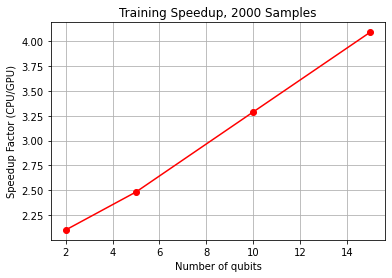

In [10]:
"""
GPU VS CPU TRAINING - constant sample size, variable system size
PLOT OF SPEEDUP FACTOR, CPU/GPU
"""

# GPU data coppied from data returned from GPU cell 
GPU_data_qubits = np.array([0.9344315528869629, 2.846299409866333, 8.077572107315063, 15.557657480239868])

# CPU data coppied from data returned from CPU cell 
CPU_data_qubits = np.array([1.9646918773651123, 7.070133686065674, 26.55202317237854, 63.61357593536377])
speedup_factor_qubits = CPU_data_qubits/GPU_data_qubits

plt.figure()
plt.plot(spins, speedup_factor_qubits, '-o', color='red')
plt.xlabel("Number of qubits")
plt.ylabel("Speedup Factor (CPU/GPU)")
plt.title("Training Speedup, 2000 Samples")
plt.grid()
plt.savefig("speedup_factor_qubits.png")
plt.show()

In [11]:
"""CONSTANTS FOR TESTING VARIABLE SAMPLE SIZE"""

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

qubits = 5
num_samples = [1000, 5000, 10000, 15000]

In [12]:
"""
GPU TRAINING - constant number of qubits, variable sample size 
Must have runtime hardware set to GPU when running this cell.
"""

training_times_GPU = []

for sample_size in num_samples:
  print("Sample size: " + str(sample_size))
  training_times_GPU.append(train(qubits, sample_size, 0.5))

print("Training times for constant system size, variable sample size:")
print(training_times_GPU)

Sample size: 1000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Sample size: 5000
Sample size: 10000
Sample size: 15000
Training times for constant system size, variable sample size:
[2.951446294784546, 2.863300323486328, 2.945936679840088, 2.9582855701446533]


In [15]:
"""
CPU TRAINING - constant number of qubits, variable sample size.
Must have runtime hardware set to CPU when running this cell. 
"""

training_times_CPU = []

for sample_size in num_samples:
  print("Sample size: " + str(sample_size))
  training_times_CPU.append(train(qubits, sample_size, 0.5))

print("Training times for constant system size, variable sample size:")
print(training_times_CPU)

Sample size: 1000


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:795: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


Sample size: 5000
Sample size: 10000
Sample size: 15000
Training times for constant system size, variable sample size:
[4.710643291473389, 14.043808221817017, 25.882484674453735, 36.5569589138031]


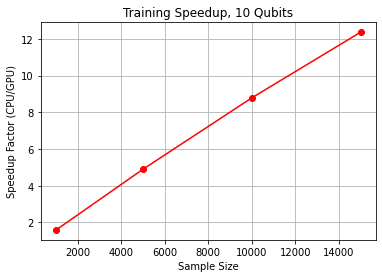

In [13]:
"""GPU VS CPU TRAINING - constant system size, variable sample size"""

# data coppied from GPU/CPU cells 
GPU_data_samples = np.array([2.951446294784546, 2.863300323486328, 2.945936679840088, 2.9582855701446533])
CPU_data_samples = np.array([4.710643291473389, 14.043808221817017, 25.882484674453735, 36.5569589138031])

speedup_factor = CPU_data_samples/GPU_data_samples

plt.figure()
plt.plot(num_samples, speedup_factor, '-o', color='red')
plt.xlabel("Sample Size")
plt.ylabel("Speedup Factor (CPU/GPU)")
plt.title("Training Speedup, 10 Qubits")
plt.grid()
plt.savefig("speedup_factor_samples.png")
plt.show()
